In [1]:
import sys
sys.path.append("..")  # or wherever your src/ lives relative to the notebook

In [2]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

import matplotlib.pyplot as plt

from src.models import FashionMNISTBaseline, FashionMNISTCNN
from src.training import train_model, evaluate

from pathlib import Path


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download the training and test datasets
full_dataset = datasets.FashionMNIST(
    root="../data/",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="../data/",
    train=False,
    download=True,
    transform=transform
)

In [4]:
train_len = int(len(full_dataset) * 0.8)
val_len = len(full_dataset) - train_len
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])

In [5]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Image shape: torch.Size([1, 28, 28])
image.squeeze() shape: torch.Size([28, 28])


Text(0.5, 1.0, 'T-shirt/top')

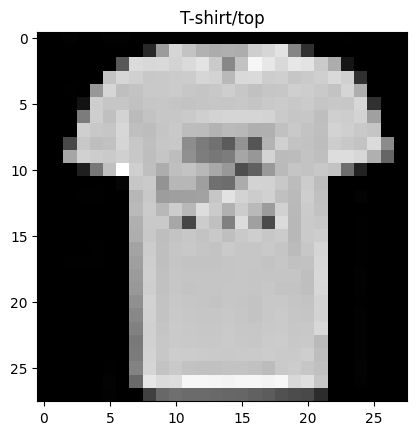

In [6]:
image, label = train_dataset[0]

print(f"Image shape: {image.shape}")

print(f"image.squeeze() shape: {image.squeeze().shape}")

class_names = full_dataset.classes

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

In [ ]:
print(f"Available device is: {device}")
base_model = FashionMNISTBaseline(
    hidden_layers= 20, # number of units in hidden layer
    output_dimension= len(class_names)
)
base_model.to(device)

In [7]:
# define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.05, momentum=0.9)
writer = SummaryWriter()


In [ ]:
train_model(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_func=loss_func,
    optimizer=optimizer,
    device=device,
    epochs=20, 
    writer = writer
)

In [ ]:
evaluate(
    model=base_model,
    data_loader=test_loader,
    loss_func=loss_func,
    device=device
)

In [10]:
# Save model weights only
save_path = Path("../models/fc_fashionmnist_epoch20.pth")
torch.save(base_model.state_dict(), save_path)

In [13]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Available device is: {device}")
cnn_model = FashionMNISTCNN(
    output_dimension=len(class_names)
)
cnn_model.to(device)

# define loss function and optimizers
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=cnn_model.parameters(), lr=0.001)
writer = SummaryWriter()


Available device is: mps


In [14]:
train_model(
    model=cnn_model,
    train_loader=train_loader,
    validation_loader=val_loader,
    loss_func=loss_func,
    optimizer=optimizer,
    device=device,
    epochs=20, 
    writer=writer
)

Epoch 1/20
Train Loss: 0.3856, Train Accuracy: 86.26%
Validation Loss: 0.3202, Validation Accuracy: 88.65%
Epoch 2/20
Train Loss: 0.2568, Train Accuracy: 90.56%
Validation Loss: 0.2455, Validation Accuracy: 91.28%
Epoch 3/20
Train Loss: 0.2152, Train Accuracy: 92.12%
Validation Loss: 0.2405, Validation Accuracy: 91.42%
Epoch 4/20
Train Loss: 0.1877, Train Accuracy: 93.07%
Validation Loss: 0.2260, Validation Accuracy: 91.90%
Epoch 5/20
Train Loss: 0.1666, Train Accuracy: 93.87%
Validation Loss: 0.2198, Validation Accuracy: 92.37%
Epoch 6/20
Train Loss: 0.1469, Train Accuracy: 94.55%
Validation Loss: 0.2373, Validation Accuracy: 91.89%
Epoch 7/20
Train Loss: 0.1280, Train Accuracy: 95.25%
Validation Loss: 0.2348, Validation Accuracy: 92.20%
Epoch 8/20
Train Loss: 0.1107, Train Accuracy: 95.92%
Validation Loss: 0.2538, Validation Accuracy: 91.69%
Epoch 9/20
Train Loss: 0.0958, Train Accuracy: 96.41%
Validation Loss: 0.2446, Validation Accuracy: 92.52%
Epoch 10/20
Train Loss: 0.0888, Train

KeyboardInterrupt: 

In [ ]:
evaluate(
    model=cnn_model,
    data_loader=test_loader,
    loss_func=loss_func,
    device=device
)

In [11]:
# Save model weights only
save_path = Path("../models/cnn_fashionmnist_epoch20.pth")
torch.save(cnn_model.state_dict(), save_path)

In [ ]:
import matplotlib.pyplot as plt

filters = cnn_model.conv_layers[0].block[0].weight.data.cpu().numpy()
filters = filters - filters.min()
filters = filters / filters.max()

fig, axs = plt.subplots(8, 8, figsize=(6, 6))
for i in range(64):
    ax = axs[i // 8, i % 8]
    ax.imshow(filters[i][0], cmap='gray')
    ax.axis("off")

plt.suptitle("First Conv Layer Filters")
plt.show()

In [20]:
def visualize_activations(model, image_tensor):
    model.eval()
    x = image_tensor.unsqueeze(0)  # Add batch dim
    x.to(device)
    activations = []

    # Hook into each conv block
    for layer in model.conv_layers:
        x = layer(x)
        activations.append(x)

    for i, act in enumerate(activations):
        fig, axs = plt.subplots(8, 8, figsize=(12, 6))
        for j in range(min(64, act.shape[1])):
            ax = axs[j // 8, j % 8]
            ax.imshow(act[0, j].detach().cpu(), cmap="gray")
            ax.axis("off")
        plt.suptitle(f"Activations after ConvBlock {i+1}")
        plt.show()

In [ ]:

x = test_dataset[0][0].unsqueeze(0)
plt.imshow(x.squeeze(), cmap="gray")
plt.title("Original Image")


In [ ]:
x = x.to(device)
x = cnn_model.conv_layers[0](x)
fig, axs = plt.subplots(8, 8, figsize=(8, 8))

for j in range(64):
    ax = axs[j // 8, j % 8]
    ax.imshow(x[0, j].detach().cpu(), cmap="gray")
    ax.axis("off")
plt.suptitle("Activations after ConvBlock 1")
plt.show()